In [5]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from glob import glob
from datetime import datetime
import sys
import itertools
import dask
import dask.dataframe as dd 

sys.path.append('/projects/dedu0223/spicy-snow/')

from spicy_snow.processing.snow_index import calc_delta_cross_ratio, calc_delta_gamma, \
    clip_delta_gamma_outlier, calc_snow_index, calc_snow_index_to_snow_depth
from spicy_snow.processing.wet_snow import id_newly_wet_snow, id_wet_negative_si, \
    id_newly_frozen_snow, flag_wet_snow


In [85]:
def add_s1_depths(row):
    c = row.C
    
    ds = calc_snow_index_to_snow_depth(dsB, C=c, inplace=False)
    bias_wet, bias, rmse_wet, rmse = get_bias(ds, closest_ts)
    return bias_wet, bias, rmse_wet, rmse

def get_bias(ds, closest_ts):
    ds_closest_ts = ds.sel(time=closest_ts, method = 'nearest')
    
    mask_wet = ~(pd.isnull(ds_closest_ts['lidar-sd']) | pd.isnull(ds_closest_ts['snow_depth']) | 
                        ds_closest_ts['wet_snow'].astype(bool))
    bias_wet = ((ds_closest_ts['lidar-sd'] - ds_closest_ts['snow_depth']).where(mask_wet)).mean()
    rmse_wet = np.sqrt(((ds_closest_ts['lidar-sd'].where(mask_wet) - ds_closest_ts['snow_depth'].where(mask_wet))**2).sum()/mask_wet.sum()).values 
    
                # Compare snow depths - no wet snow mask
    mask = ~(pd.isnull(ds['lidar-sd']) | pd.isnull(ds['snow_depth'].sel(time=closest_ts)))
    bias = (ds['lidar-sd'].where(mask) - ds['snow_depth'].sel(time=closest_ts).where(mask)).mean()
    rmse = np.sqrt(((ds_closest_ts['lidar-sd'].where(mask) - ds_closest_ts['snow_depth'].where(mask))**2).sum()/mask.sum()).values
    
    return bias_wet.values, bias.values, rmse_wet, rmse

def change_b(ds, b):
    ds = calc_delta_gamma(ds, B=b, inplace=False)
    ds = clip_delta_gamma_outlier(ds)
    ds = calc_snow_index(ds)
    ds = id_newly_wet_snow(ds)
    ds = id_wet_negative_si(ds)
    ds = id_newly_frozen_snow(ds)
    ds = flag_wet_snow(ds)
    return ds

In [82]:
A = [1]
B = [1]
C = np.arange(0, 2, 0.05)

all_biases = pd.DataFrame({'C':C})

In [93]:
# %%time
files = sorted(glob('/projects/dedu0223/snow_ex_data/*.nc'))

for f in files[4:5]:
    ds_name = f.split('stacks/')[-1].split('.')[0].split('/')[-1]
    
    if ds_name not in ['Banner_2021-03-15']:
        print(datetime.now(), f' -- starting {ds_name}')
        ds_ = xr.open_dataset(f).load() # Open dataset 


        dataset = ds_[['s1','deltaVV','ims','fcf','lidar-sd']]

        td = abs(pd.to_datetime(dataset.time) - pd.to_datetime(dataset.attrs['lidar-flight-time']))
        closest_ts_idx = np.where(td == td.min())[0][0]
        closest_ts = dataset.time[closest_ts_idx]

        for a in A:
            dsA = calc_delta_cross_ratio(dataset, A=a, inplace=False)
            for b in B:
                dsB = change_b(dsA, b)
                dfC = pd.DataFrame({'C':C})

                ddf = dd.from_pandas(dfC, npartitions=8)
                output_series = ddf.apply(add_s1_depths, axis=1, result_type='expand', meta=({0: float, 1: float, 2:float, 3:float}))
                output_series = output_series.compute()

                all_biases[f'{ds_name}_wet_bias'] = output_series[0]
                all_biases[f'{ds_name}_bias'] = output_series[1]
                all_biases[f'{ds_name}_wet_rmse'] = output_series[2]
                all_biases[f'{ds_name}_rmse'] = output_series[3]

2023-04-19 16:15:18.417354  -- starting Frasier_2020-02-11


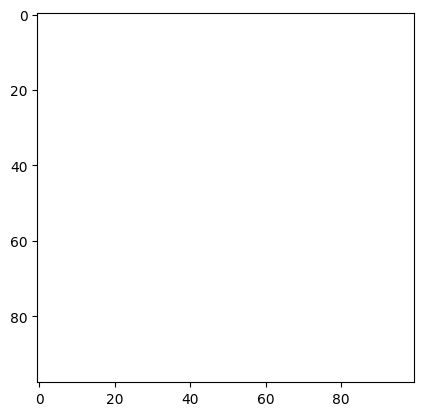

In [99]:
plt.imshow(dsA.isel(time = 1).deltaCR)

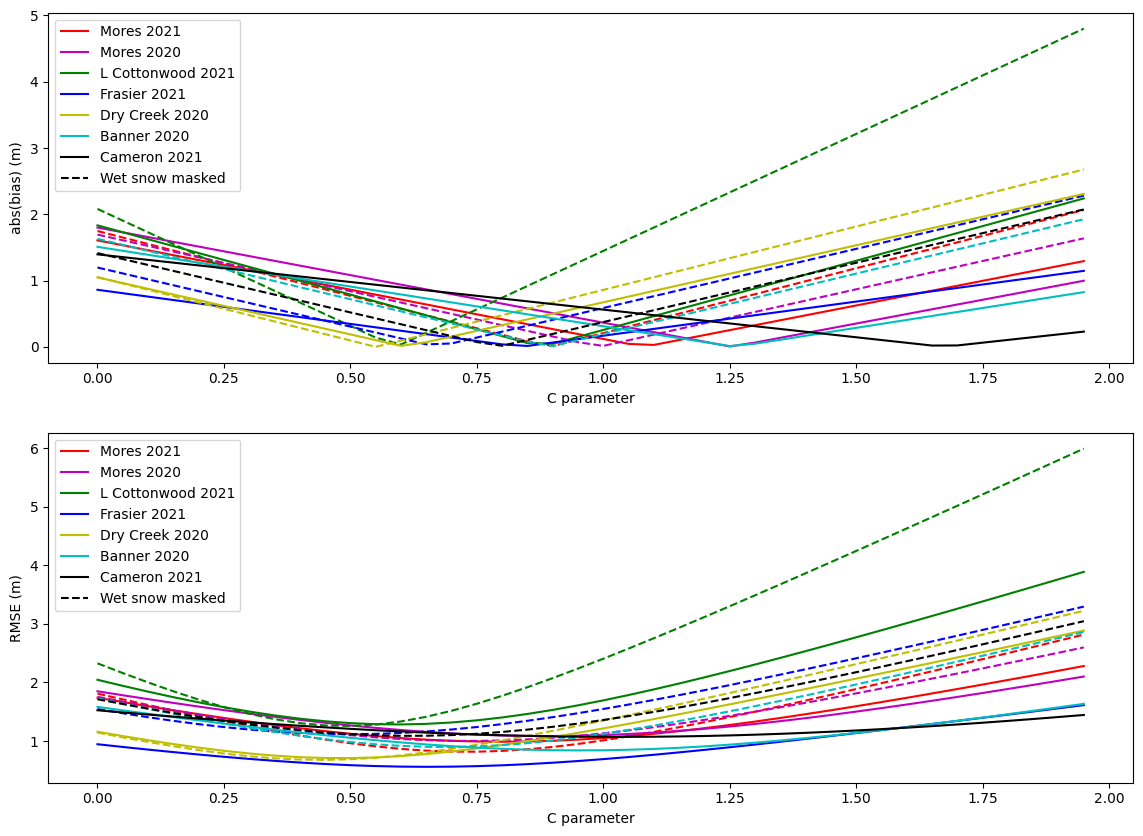

In [89]:
fig, ax = plt.subplots(2,1,figsize = (14,10))

ax[0].plot(all_biases.C, np.abs(all_biases['Mores_2021-03-15_bias']),'r', label = 'Mores 2021')
ax[0].plot(all_biases.C, np.abs(all_biases['Mores_2021-03-15_wet_bias']),'r--')

ax[0].plot(all_biases.C, np.abs(all_biases['Mores_2020-02-09_bias']),'m', label = 'Mores 2020')
ax[0].plot(all_biases.C, np.abs(all_biases['Mores_2020-02-09_wet_bias']),'m--')

ax[0].plot(all_biases.C, np.abs(all_biases['Little_Cottonwood_2021-03-18_bias']),'g', label = 'L Cottonwood 2021')
ax[0].plot(all_biases.C, np.abs(all_biases['Little_Cottonwood_2021-03-18_wet_bias']),'g--')

ax[0].plot(all_biases.C, np.abs(all_biases['Frasier_2021-03-19_bias']),'b', label = 'Frasier 2021')
ax[0].plot(all_biases.C, np.abs(all_biases['Frasier_2021-03-19_wet_bias']),'b--')

ax[0].plot(all_biases.C, np.abs(all_biases['Dry_Creek_2020-02-19_bias']),'y', label = 'Dry Creek 2020')
ax[0].plot(all_biases.C, np.abs(all_biases['Dry_Creek_2020-02-19_wet_bias']),'y--')

ax[0].plot(all_biases.C, np.abs(all_biases['Banner_2020-02-18_bias']),'c', label = 'Banner 2020')
ax[0].plot(all_biases.C, np.abs(all_biases['Banner_2020-02-18_wet_bias']),'c--')

ax[0].plot(all_biases.C, np.abs(all_biases['Cameron_2021-03-19_bias']),'k', label = 'Cameron 2021')
ax[0].plot(all_biases.C, np.abs(all_biases['Cameron_2021-03-19_wet_bias']),'k--', label = 'Wet snow masked')

ax[0].legend()
ax[0].set_xlabel('C parameter')
ax[0].set_ylabel('abs(bias) (m)')

ax[1].plot(all_biases.C, np.abs(all_biases['Mores_2021-03-15_rmse']),'r', label = 'Mores 2021')
ax[1].plot(all_biases.C, np.abs(all_biases['Mores_2021-03-15_wet_rmse']),'r--')

ax[1].plot(all_biases.C, np.abs(all_biases['Mores_2020-02-09_rmse']),'m', label = 'Mores 2020')
ax[1].plot(all_biases.C, np.abs(all_biases['Mores_2020-02-09_wet_rmse']),'m--')

ax[1].plot(all_biases.C, np.abs(all_biases['Little_Cottonwood_2021-03-18_rmse']),'g', label = 'L Cottonwood 2021')
ax[1].plot(all_biases.C, np.abs(all_biases['Little_Cottonwood_2021-03-18_wet_rmse']),'g--')

ax[1].plot(all_biases.C, np.abs(all_biases['Frasier_2021-03-19_rmse']),'b', label = 'Frasier 2021')
ax[1].plot(all_biases.C, np.abs(all_biases['Frasier_2021-03-19_wet_rmse']),'b--')

ax[1].plot(all_biases.C, np.abs(all_biases['Dry_Creek_2020-02-19_rmse']),'y', label = 'Dry Creek 2020')
ax[1].plot(all_biases.C, np.abs(all_biases['Dry_Creek_2020-02-19_wet_rmse']),'y--')

ax[1].plot(all_biases.C, np.abs(all_biases['Banner_2020-02-18_rmse']),'c', label = 'Banner 2020')
ax[1].plot(all_biases.C, np.abs(all_biases['Banner_2020-02-18_wet_rmse']),'c--')

ax[1].plot(all_biases.C, np.abs(all_biases['Cameron_2021-03-19_rmse']),'k', label = 'Cameron 2021')
ax[1].plot(all_biases.C, np.abs(all_biases['Cameron_2021-03-19_wet_rmse']),'k--', label = 'Wet snow masked')

ax[1].legend()
ax[1].set_xlabel('C parameter')
ax[1].set_ylabel('RMSE (m)')

plt.savefig('/projects/dedu0223/spicy-snow/images/bias_rmse_opt.png')


In [91]:
all_biases['Frasier_2020-02-11_bias']

0     nan
1     nan
2     nan
3     nan
4     nan
5     nan
6     nan
7     nan
8     nan
9     nan
10    nan
11    nan
12    nan
13    nan
14    nan
15    nan
16    nan
17    nan
18    nan
19    nan
20    nan
21    nan
22    nan
23    nan
24    nan
25    nan
26    nan
27    nan
28    nan
29    nan
30    nan
31    nan
32    nan
33    nan
34    nan
35    nan
36    nan
37    nan
38    nan
39    nan
Name: Frasier_2020-02-11_bias, dtype: object

In [57]:
import pickle

In [58]:
with open('param_opt_bias.p', 'wb') as f:
    pickle.dump(all_biases, f)

In [24]:
# dataset_lowf = dataset.where((dataset.fcf<0.25))
# dataset_midf = dataset.where((dataset.fcf<0.75) & (dataset.fcf>0.25))
# dataset_highf = dataset.where((dataset.fcf>0.75))

# all_datasets = [dataset_lowf, dataset_midf, dataset_highf, dataset]
# all_rmse_datasets = list()

#         for row in dfC.iterrows():
#                 rmse_wet_flag.loc[a, b, row[1].C] = row[1].rmse_wet
#                 rmse_no_flag.loc[a, b, row[1].C] = row[1].rmse
                
#     all_rmse_datasets.append(rmse_wet_flag)

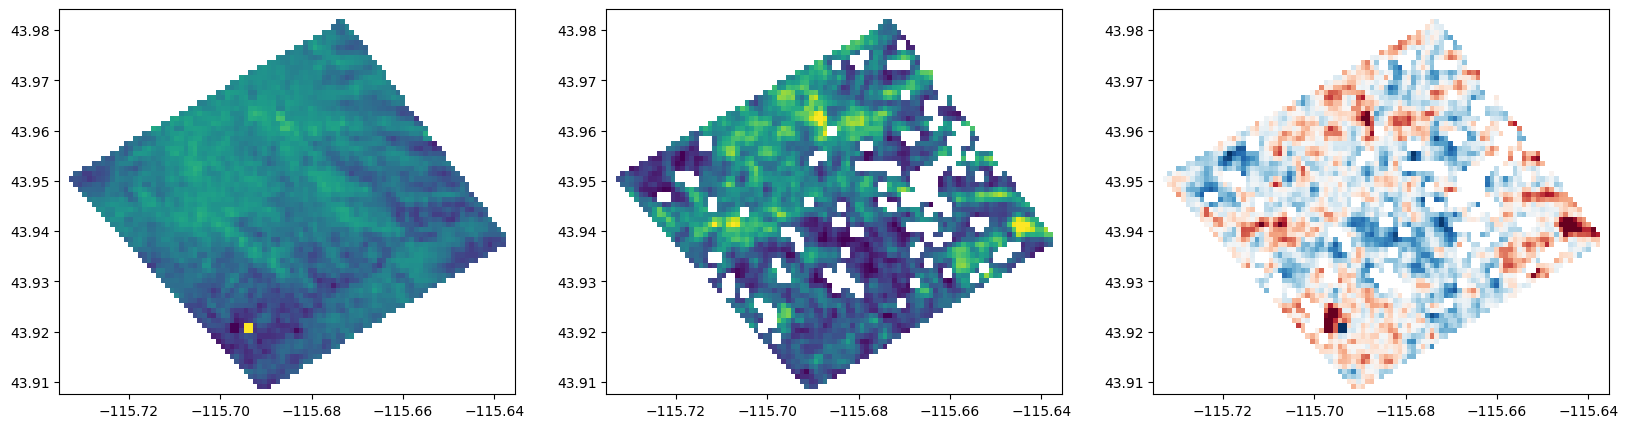

In [63]:
fig, ax = plt.subplots(1,3,figsize = (20,5))

ax[0].pcolormesh(closest_ds.x, closest_ds.y, lidar, vmin = 0, vmax = 4)
ax[1].pcolormesh(closest_ds.x, closest_ds.y, s1, vmin = 0, vmax = 4)
ax[2].pcolormesh(closest_ds.x, closest_ds.y, lidar - s1, vmin = -2, vmax = 2, cmap = 'RdBu')

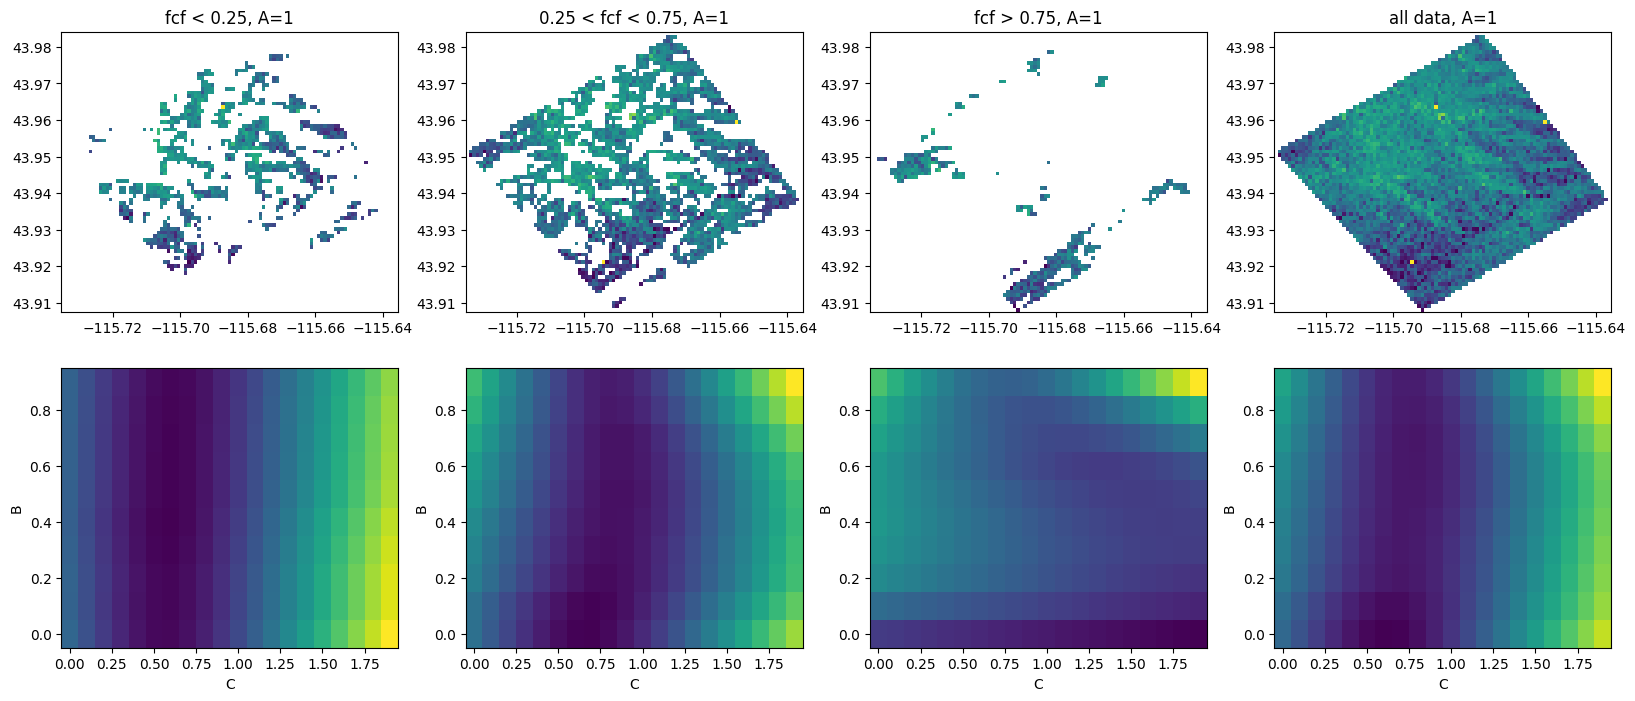

In [5]:
fig, ax = plt.subplots(2,4, figsize = (20,8))
titles = ['fcf < 0.25, A=1', '0.25 < fcf < 0.75, A=1', 'fcf > 0.75, A=1', 'all data, A=1']

for i in range(len(all_rmse_datasets)):
    d1 = all_datasets[i]
    ax[0,i].pcolormesh(d1.x, d1.y, d1['lidar-sd'], vmin = 0, vmax = 4)
    ax[0,i].set_title(titles[i])
    
    d = all_rmse_datasets[i].sel(A=1)
    ax[1,i].pcolormesh(d.C, d.B, d)
    ax[1,i].set_xlabel('C')
    ax[1,i].set_ylabel('B')

